# SI 618 - Homework #6: Machine Learning 1

Version 2023.11.01.1.CT

In this homework exercise you will apply the machine learning techniques we've covered so far: 
machine learning pipelines, dimension reduction, and clustering.

You will be using the [customer personality analysis dataset](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis) from Kaggle.

**NOTE:** This is a fairly involved homework assignment and we *strongly* urge you to not leave this to the last minute.
We suggest that you try to work on this assignment over several days.

A reminder (from the syllabus):
> Unless stated otherwise in an assignment, you are permitted to use generative AI (e.g. ChatGPT, Copilot, etc.) but you must indicate  that you did so in the work that you submit.  **If you fail to 
>  disclose your use of generative AI you will receive a grade of
> zero on the assignment**.

### The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, punctuation, etc. of written sentences. ([Guide](https://drive.google.com/file/d/1L0P7xJwjUGBvyb49mL3dw1Bt7hzRTiTl/view ))
- 10 pt: Code is written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

In [1]:
MY_UNIQNAME = 'prathuj' # fill this in with your uniqname

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib.cm as cm # colormaps
import matplotlib.pyplot as plt
# plt.style.use("dark_background")
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
import xgboost as xgb

import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

## Task 1 (10 points):
Perform exploratory data analyses on the variables in this dataset.  Your work should include both
numerical **and** graphical overviews of the data.  Explain your findings.  

In [3]:
marketing = pd.read_csv('marketing_campaign.csv', sep='\t')

In [4]:
id = ['ID']

purchase = ['MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds']

place = [ 'NumWebPurchases', 'NumCatalogPurchases',
         'NumStorePurchases', 'NumWebVisitsMonth']

promotion = ['NumDealsPurchases','AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
              'AcceptedCmp4', 'AcceptedCmp5', 'Response']

demographic_1 = ['Year_Birth', 'Dt_Customer', 'Education', 'Marital_Status',
                 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Complain']

demographic_2 = ['Age', 'Education', 'In_Relationship',  'Income',
               'Kidhome', 'Teenhome', 'Recency', 'Complain']

date = ['Dt_Customer']

constants = ['Z_CostContact', 'Z_Revenue']

### Feature Engineering

In [5]:
print('Length of the dataset: ', len(marketing))

Length of the dataset:  2240


In [6]:
# convert 'Year_Birth' to 'Age'
marketing['Age'] = 2023 - marketing['Year_Birth']
marketing = marketing.drop('Year_Birth', axis=1)

In [7]:
# convert 'Dt_Customer' to weekday
marketing['Dt_Customer'] = pd.to_datetime(marketing['Dt_Customer'],
                                          format='%d-%m-%Y').dt.dayofweek
# convert to Sunday, Monday ... Saturday
marketing['Dt_Customer'] = marketing['Dt_Customer'].replace({
    0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday',
    4: 'Thursday', 5: 'Friday', 6: 'Saturday'})

In [8]:
marketing.describe()

ID         Income      Kidhome     Teenhome      Recency  \
count   2240.000000    2216.000000  2240.000000  2240.000000  2240.000000   
mean    5592.159821   52247.251354     0.444196     0.506250    49.109375   
std     3246.662198   25173.076661     0.538398     0.544538    28.962453   
min        0.000000    1730.000000     0.000000     0.000000     0.000000   
25%     2828.250000   35303.000000     0.000000     0.000000    24.000000   
50%     5458.500000   51381.500000     0.000000     0.000000    49.000000   
75%     8427.750000   68522.000000     1.000000     1.000000    74.000000   
max    11191.000000  666666.000000     2.000000     2.000000    99.000000   

          MntWines    MntFruits  MntMeatProducts  MntFishProducts  \
count  2240.000000  2240.000000      2240.000000      2240.000000   
mean    303.935714    26.302232       166.950000        37.525446   
std     336.597393    39.773434       225.715373        54.628979   
min       0.000000     0.000000         0.000000         0.000000   
25%      23.750000     1.000000        16.000000         3.000000   
50%     173.500000     8.000000        67.000000        12.000000   
75%     504.250000    33.000000       232.000000        50.000000   
max    1493.000000   199.000000      1725.000000       259.000000   

       MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
count       2240.000000   2240.000000        2240.000000      2240.000000   
mean          27.062946     44.021875           2.325000         4.084821   
std           41.280498     52.167439           1.932238         2.778714   
min            0.000000      0.000000           0.000000         0.000000   
25%            1.000000      9.000000           1.000000         2.000000   
50%            8.000000     24.000000           2.000000         4.000000   
75%           33.000000     56.000000           3.000000         6.000000   
max          263.000000    362.000000          15.000000        27.000000   

       NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  \
count          2240.000000        2240.000000        2240.000000   
mean              2.662054           5.790179           5.316518   
std               2.923101           3.250958           2.426645   
min               0.000000           0.000000           0.000000   
25%               0.000000           3.000000           3.000000   
50%               2.000000           5.000000           6.000000   
75%               4.000000           8.000000           7.000000   
max              28.000000          13.000000          20.000000   

       AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  \
count   2240.000000   2240.000000   2240.000000   2240.000000   2240.000000   
mean       0.072768      0.074554      0.072768      0.064286      0.013393   
std        0.259813      0.262728      0.259813      0.245316      0.114976   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

          Complain  Z_CostContact  Z_Revenue     Response          Age  
count  2240.000000         2240.0     2240.0  2240.000000  2240.000000  
mean      0.009375            3.0       11.0     0.149107    54.194196  
std       0.096391            0.0        0.0     0.356274    11.984069  
min       0.000000            3.0       11.0     0.000000    27.000000  
25%       0.000000            3.0       11.0     0.000000    46.000000  
50%       0.000000            3.0       11.0     0.000000    53.000000  
75%       0.000000            3.0       11.0     0.000000    64.000000  
max       1.000000            3.0       11.0     1.000000   130.000000

### Numerical Summary
- I have computed `Age` by taking difference of `Year_Birth` with 2023
- Transformed `Dt_Customer` to give dayof the week value
- `NumStorePurchases` tend to be higher than other purchase methods
- `Z_CostContact` and `Z_Revenue` are constant variables


### Graphical Summary

Plot of Demographic features

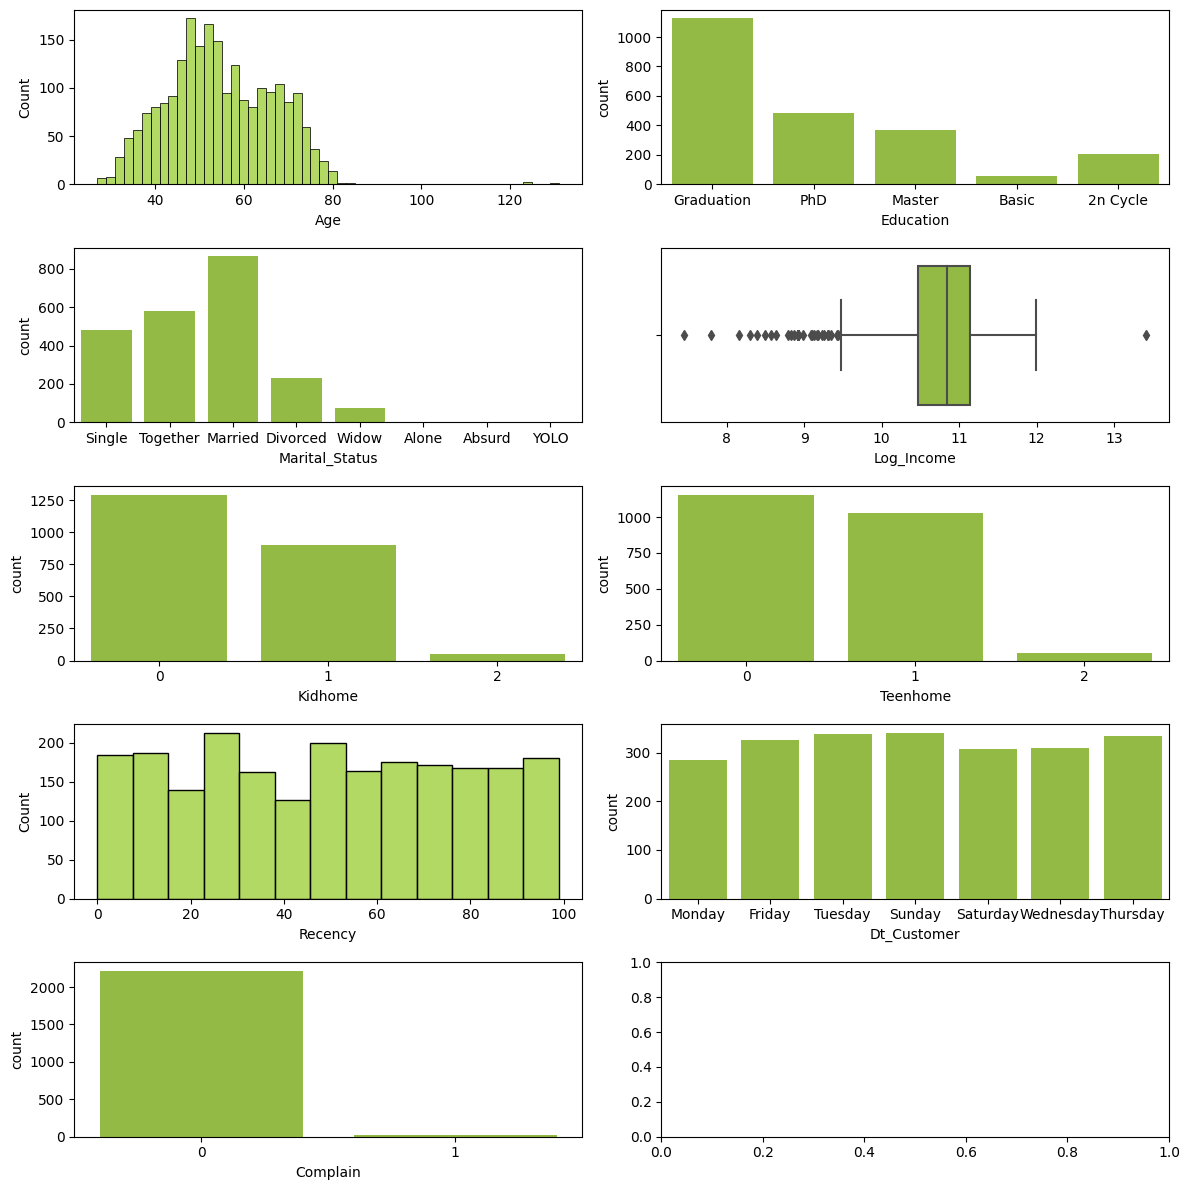

In [9]:
fig, axes = plt.subplots(5, 2, figsize=(12, 12))

sns.histplot(marketing['Age'], ax=axes[0, 0], color='yellowgreen', binwidth=2)
sns.countplot(data=marketing, x = 'Education' ,ax=axes[0, 1], color='yellowgreen')
sns.countplot(data=marketing, x = 'Marital_Status' ,ax=axes[1, 0], color='yellowgreen')
# log scale for income
marketing['Log_Income'] = np.log(marketing['Income'])
sns.boxplot(data=marketing, x = 'Log_Income' ,ax=axes[1, 1], color='yellowgreen')
marketing.drop('Log_Income', axis=1, inplace=True)
sns.countplot(data=marketing, x = 'Kidhome' ,ax=axes[2, 0], color='yellowgreen')
sns.countplot(data=marketing, x = 'Teenhome' ,ax=axes[2, 1], color='yellowgreen')
sns.histplot(marketing['Recency'], ax=axes[3, 0], color='yellowgreen')
sns.countplot(data=marketing, x = 'Dt_Customer' ,ax=axes[3, 1], color='yellowgreen')
sns.countplot(data=marketing, x = 'Complain' ,ax=axes[4, 0], color='yellowgreen')
plt.tight_layout()
plt.show()

- Median `Age` is about 50
- Majority people have completed *Grduation* and are *Married*
- Plotted the `Income` on Log scale for better interpretation

Plot of Purchase features

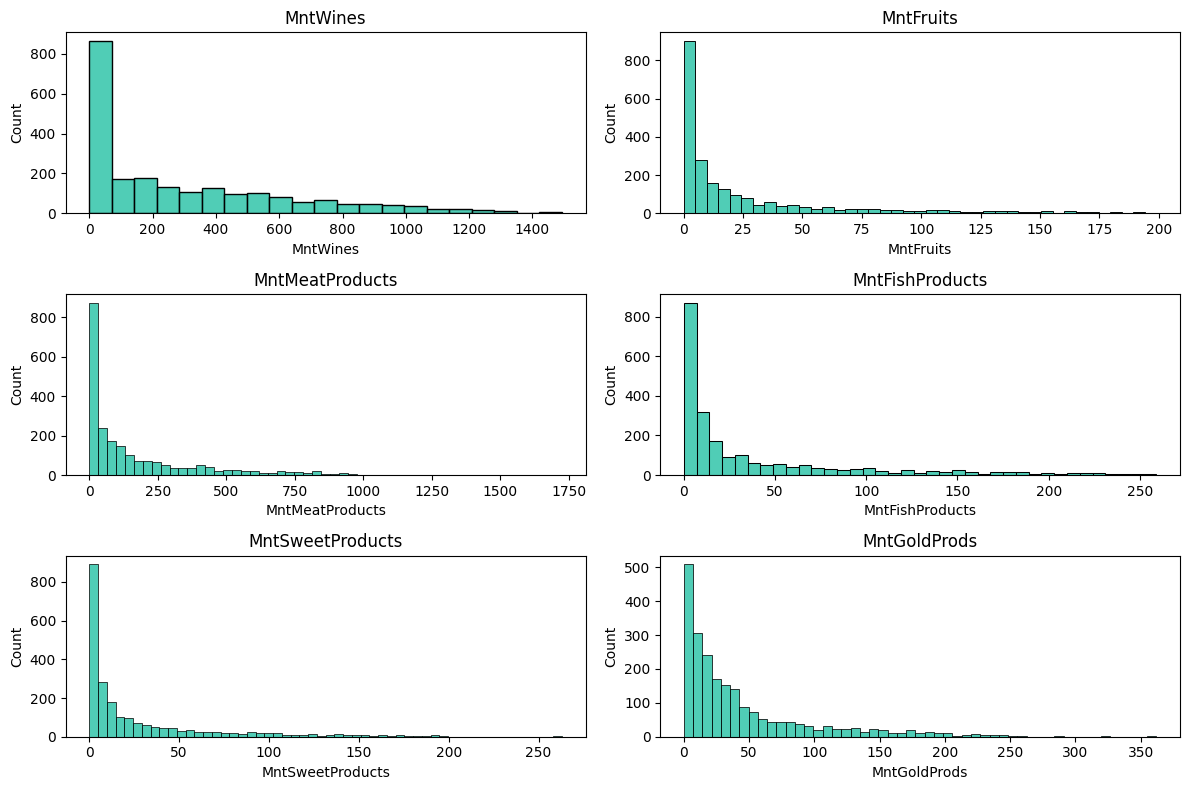

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    sns.histplot(marketing[purchase[i]], ax=ax, color='#15bd9e')
    ax.set_title(purchase[i])
plt.tight_layout()
plt.show()

- People have spent more on *Wines* and *MeatProducts* than other products

Plot of Place features

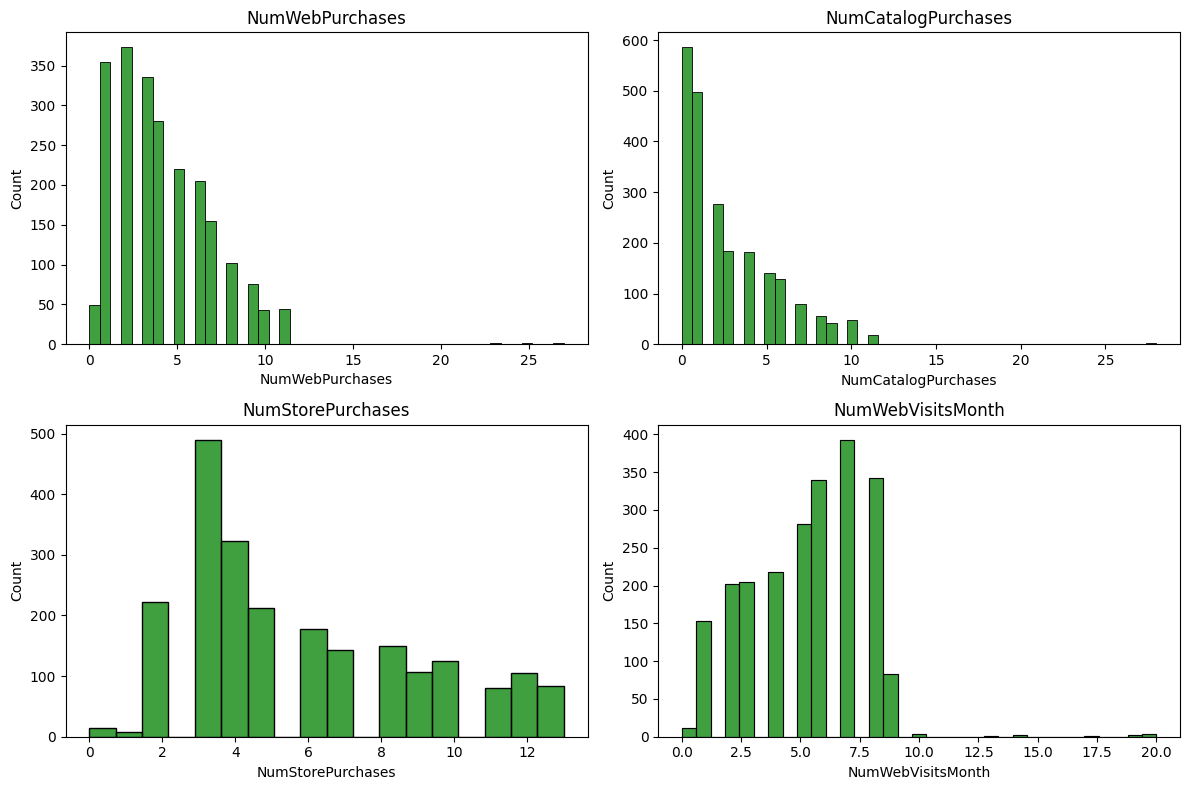

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    sns.histplot(marketing[place[i]], ax=ax, color='green')
    ax.set_title(place[i])
plt.tight_layout()
plt.show()

- `NumStorePurchases` tend to be higher than other purchase methods

Plot of Promotion features

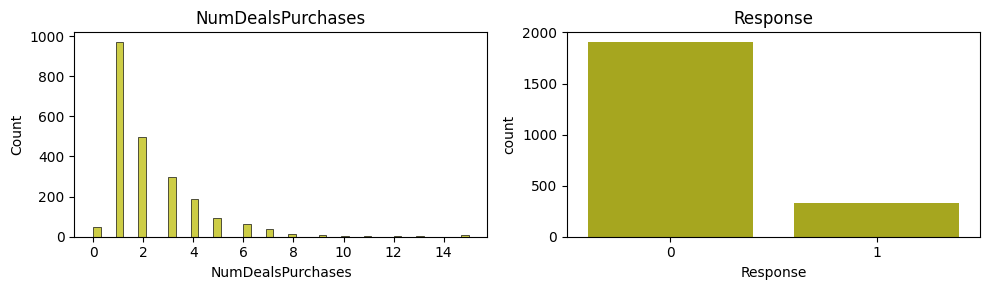

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.histplot(marketing['NumDealsPurchases'], ax=axes[0], color='#bdbd08')
axes[0].set_title('NumDealsPurchases')
sns.countplot(data=marketing, x = 'Response' ,ax=axes[1], color='#bdbd08')
axes[1].set_title('Response')
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


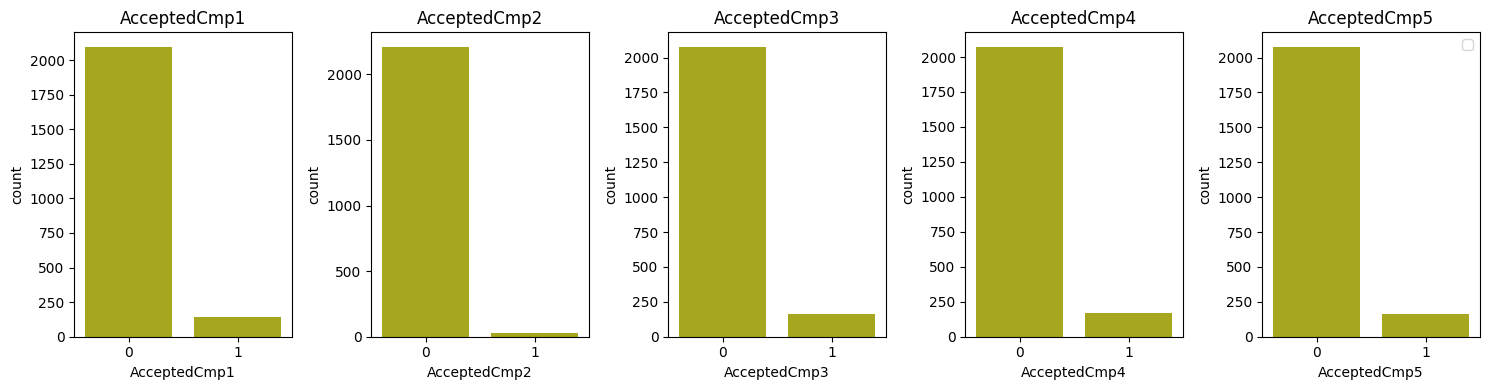

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
promotion2 = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
              'AcceptedCmp4', 'AcceptedCmp5']

for i, col in enumerate(promotion2):
    sns.countplot(data=marketing, x = col ,ax=axes[i], color='#bdbd08')
    axes[i].set_title(col)
plt.legend()
plt.tight_layout()
plt.show()

- Very few times the promotions were accepted by the customers.

## Task 2 (1 point): Drop all columns that have constant values.

In [14]:
# print value_counts of constants
for col in constants:
    print(marketing[col].value_counts())

Z_CostContact
3    2240
Name: count, dtype: int64
Z_Revenue
11    2240
Name: count, dtype: int64


`Z_CostContact` and `Z_Revenue` have constant values and so we will drop them.

In [15]:
# drop constant columns
marketing.drop(columns=['Z_CostContact', 'Z_Revenue'], inplace=True)

## Task 3 (1 point):
Create a new variable `In_Relationship` whose value is 1 if the value of `Marital_Status` is "Married" or "Together" and 0 otherwise.  Drop the `Marital_Status` column.

In [16]:
# insert your code here
marketing['In_Relationship'] = marketing['Marital_Status'].apply(
    lambda x: 1 if (x == 'Married' or x == 'Together') else 0)
marketing.drop(['Marital_Status'], axis=1, inplace=True)
marketing.head()

ID   Education   Income  Kidhome  Teenhome Dt_Customer  Recency  \
0  5524  Graduation  58138.0        0         0      Monday       58   
1  2174  Graduation  46344.0        1         1      Friday       38   
2  4141  Graduation  71613.0        0         0     Tuesday       26   
3  6182  Graduation  26646.0        1         0      Sunday       26   
4  5324         PhD  58293.0        1         0    Saturday       94   

   MntWines  MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
0       635         88              546              172                88   
1        11          1                6                2                 1   
2       426         49              127              111                21   
3        11          4               20               10                 3   
4       173         43              118               46                27   

   MntGoldProds  NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
0            88                  3                8                   10   
1             6                  2                1                    1   
2            42                  1                8                    2   
3             5                  2                2                    0   
4            15                  5                5                    3   

   NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
0                  4                  7             0             0   
1                  2                  5             0             0   
2                 10                  4             0             0   
3                  4                  6             0             0   
4                  6                  5             0             0   

   AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  Age  \
0             0             0             0         0         1   66   
1             0             0             0         0         0   69   
2             0             0             0         0         0   58   
3             0             0             0         0         0   39   
4             0             0             0         0         0   42   

   In_Relationship  
0                0  
1                0  
2                1  
3                1  
4                1

## Task 4 (3 points):
Impute missing income values with the median income.  Explain your results (i.e. what the median value was, how many values were imputed, how reliable you think the median value is, etc.).

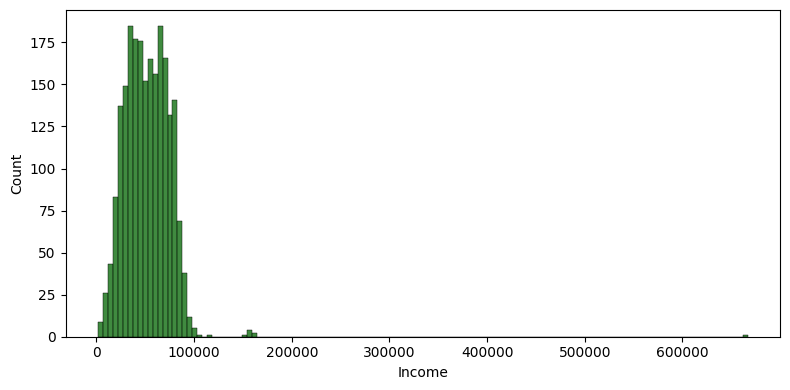

In [17]:
# plot count plot of 'Income'
plt.figure(figsize=(8, 4))
sns.histplot(data=marketing, x='Income', color='darkgreen')
plt.tight_layout()
plt.show()

In [18]:
# median value of the Income column
median = marketing['Income'].median()
print('Median value of the Income: ', median, '$')
mean = marketing['Income'].mean().__round__(2)
print('Mean value of the Income: ', mean, '$')

Median value of the Income:  51381.5 $
Mean value of the Income:  52247.25 $


In [19]:
marketing['Income'].fillna(median, inplace=True)

- Imputed 24 Missing Income values with Median Income = 51381.5 $

- Taking the median income is more appropriate when dealing with income data because it is less sensitive to extreme outliers compared to the mean income, making it a more robust measure for summarizing income distributions and reducing the impact of skewed or extreme values.

## Task 5 (15 points):
Use scikit-learn to conduct a linear regression that models the amount spend on wine (`MntWines`) based on `Income` and whether they are in a relationship (`In_Relationship`).  Assess how good your model is by reporting the root mean squared error (RMSE) using the test dataset from an 80-20 train-test-split of the original dataset.  Explain what your value of RMSE means, and comment on how good you think your model is based on the RMSE value means.

In [20]:
X = marketing[['Income','In_Relationship']]#.values.reshape(-1, 1)
y = marketing['MntWines']#.values.reshape(-1, 1)

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, 
                                                    random_state=0)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
print('RMSE of Linear Regression: ', 
      np.sqrt(mean_squared_error(y_test, y_pred)).round(2), '$')

RMSE of Linear Regression:  253.64 $


In [21]:
# mean and median of the MntWines column
mean = marketing['MntWines'].mean().__round__(2)
median = marketing['MntWines'].median().__round__(2)
print('Mean value of the MntWines: ', mean, '$')
print('Median value of the MntWines: ', median, '$')

Mean value of the MntWines:  303.94 $
Median value of the MntWines:  173.5 $


The Mean and Median value of `MntWines` is around 200 - 300 \$. Therefore when the RMSE value is 253 $, we can say that the linear regression is not a good predictor of `MntWines` for `Income` and `In_Relationship` features.

## Task 6 (20 points):
Conduct an agglomerative clustering analysis to find 4 clusters using average linkage based on PCA projections of the original data onto 5 dimensions (use one-hot encoding on your categorical variables, and remember to scale your data before doing the PCA).  Report the percentage of variance retained in the first 5 principal components. 

Do not create a dendrogram. Instead, create a scatterplot of the first two principal components, colored by cluster membership.  Comment on the results of your clustering analysis.

Repeat the above steps using 7 clusters.  Compare the results to the 4 cluster solution.  Which solution do you prefer and why?

Keep in mind that one of the goals of cluster analysis with this dataset is creating customer segments.  Can you define customer segments by examining the characteristics of each cluster? (Hint: a groupby() by cluster membership might be helpful here.)

In [22]:
def agg_clusters(df, N):
    cat_attr = df.select_dtypes(include='object').columns.tolist()
    num_attr = df.select_dtypes(include='number').columns.tolist()

    # scale cat_attr and OneHotEncode num_attr using ColumnTransformer
    pre_pr = ColumnTransformer([
        ('scale', StandardScaler(), num_attr),
        ('onehot', OneHotEncoder(sparse_output=False), cat_attr)
    ])

    # create a pipeline with preprocessor and model
    pipe = Pipeline([
        ('preprocessor', pre_pr),
        ('pca', PCA(n_components=5)),
        ('cluster', AgglomerativeClustering(n_clusters=N, linkage='average'))
    ])

    pipe_2 = Pipeline([
        ('preprocessor', pre_pr),
        ('pca', PCA(n_components=5))
    ])

    cluster_column = pipe.fit_predict(df)
    clustered_df = pd.concat([df, pd.DataFrame(cluster_column, columns=['cluster'])], axis=1)

    data_transformed = pipe_2.fit_transform(df)
    # print(data_transformed)

    # variation explained by each component
    print(pipe_2['pca'].explained_variance_ratio_)

    plot_df = pd.DataFrame(data_transformed, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

    # plot the clusters
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(plot_df['PC1'], plot_df['PC2'], c=cluster_column, cmap='rainbow')
    legend_labels = [f'Cluster {label}' for label in set(cluster_column)]
    legend = plt.legend(handles=scatter.legend_elements()[0], title="Clusters", labels=legend_labels)
    plt.gca().add_artist(legend)
    plt.legend()
    plt.show()

    return clustered_df

### Clustering for 4 clusters

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.24576638 0.07656982 0.0717502  0.05353828 0.04251014]


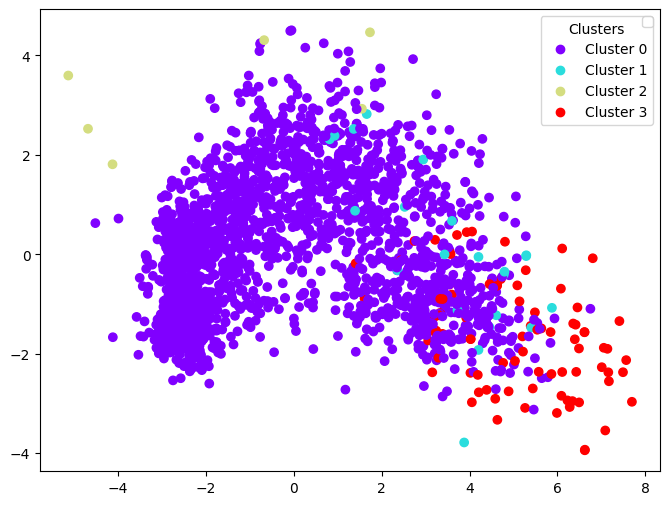

In [23]:
marketing_c4 = agg_clusters(marketing, 4)

In [24]:
binary_vars = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain']
num_vars = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
                'NumStorePurchases', 'NumWebVisitsMonth', 'In_Relationship',
                'Income', 'Age', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
            'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
            'MntGoldProds']
count_vars = ['ID']
cat_vars = ['Education', 'Dt_Customer']

def most_frequent(series):
    return series.mode().iloc[0]

In [25]:
cluster_4_df = marketing_c4.groupby('cluster').agg({'ID': 'count',
                **{col: 'sum' for col in binary_vars},
                **{col: 'mean' for col in num_vars},
                **{col: most_frequent for col in cat_vars}}).reset_index()

cluster_4_df.T

0             1             2             3
cluster                         0             1             2             3
ID                           2125            23             6            86
AcceptedCmp1                   74            11             0            59
AcceptedCmp2                    3            23             0             4
AcceptedCmp3                  143             3             0            17
AcceptedCmp4                  101            20             0            46
AcceptedCmp5                   71            14             0            78
Response                      255            15             0            64
Complain                       21             0             0             0
NumDealsPurchases        2.351529      1.869565     14.333333      0.953488
NumWebPurchases          4.024471      4.956522      3.166667      5.406977
NumCatalogPurchases      2.472941      5.347826      1.833333      6.674419
NumStorePurchases           5.672      8.347826           5.0      8.081395
NumWebVisitsMonth        5.390588      5.391304          13.5      2.895349
In_Relationship          0.643294      0.652174      0.666667      0.674419
Income               50788.540706  72434.652174  32672.833333  84016.069767
Age                     54.301176     54.652174          49.0     51.790698
Kidhome                  0.462588           0.0      0.666667      0.093023
Teenhome                 0.524706      0.478261      0.666667      0.046512
Recency                 49.180235     53.956522          63.0     45.093023
MntWines               271.932706   1036.869565    288.833333    899.744186
MntFruits               24.789647     15.086957          15.5     67.430233
MntMeatProducts        152.865882    217.130435     78.333333     507.72093
MntFishProducts         35.502588     36.826087     64.833333     85.790698
MntSweetProducts        25.215529     24.913043     44.166667     72.093023
MntGoldProds            42.124235     62.826087          54.0     85.186047
Education              Graduation    Graduation      2n Cycle    Graduation
Dt_Customer                Sunday      Thursday        Monday        Sunday

- Cluster 0: is majority class of customers, and it shows almost mean values in almost all categories. Half of the customers have kids at home, their spending is almost average, though they are the ones actively enrolling in most of the promotion activites and giving all of the complaints.
- Cluster 1: is fairly involved in accepting promotions, have no kids at home, spend most on Wines, and have mostly enrolled with the company on a Thursday
- Cluster 2: is not involved in promotion activity, has least income of all clusters, are highest in purchasing with Deals and have highest Recency
- Cluster 3: have the highest incomes, spending largest on Wines, Meat and Gold, fairly involved in accepting promotions and highest purchasers by Store and Catalogue.

### Clustering for 7 clusters

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.24576638 0.07657084 0.07175023 0.05354298 0.04249962]


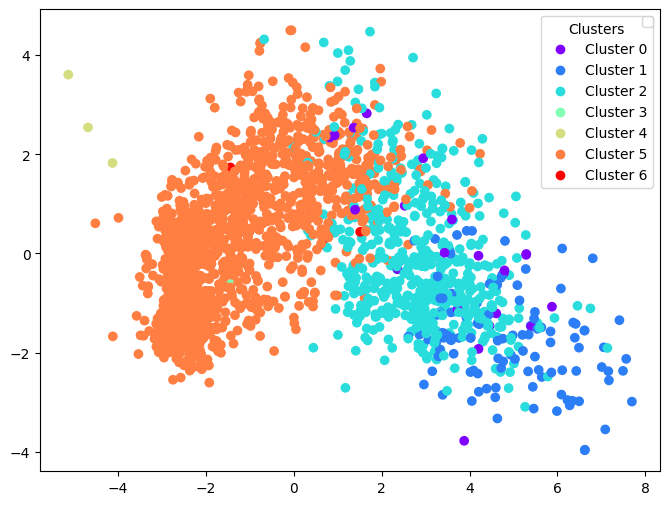

In [26]:
marketing_c7 = agg_clusters(marketing, 7)

In [27]:
cluster_7_df = marketing_c7.groupby('cluster').agg({'ID': 'count',
                **{col: 'sum' for col in binary_vars},
                **{col: 'mean' for col in num_vars},
                **{col: most_frequent for col in cat_vars}}).reset_index()

cluster_7_df.T

0             1             2           3  \
cluster                         0             1             2           3   
ID                             23           114           536           1   
AcceptedCmp1                   11            70            41           0   
AcceptedCmp2                   23             4             0           0   
AcceptedCmp3                    3            25            45           1   
AcceptedCmp4                   20            44             9           0   
AcceptedCmp5                   14            92            46           0   
Response                       15            96            79           1   
Complain                        0             1             1           1   
NumDealsPurchases        1.869565       0.95614      1.914179         4.0   
NumWebPurchases          4.956522      5.526316      5.585821         7.0   
NumCatalogPurchases      5.347826      6.359649         5.625         2.0   
NumStorePurchases        8.347826      7.903509      8.550373         3.0   
NumWebVisitsMonth        5.391304      2.807018      3.302239         9.0   
In_Relationship          0.652174      0.561404      0.641791         0.0   
Income               72434.652174  82434.890351  72667.836754     37774.0   
Age                     54.652174     52.061404     55.371269        46.0   
Kidhome                       0.0       0.04386      0.072761         2.0   
Teenhome                 0.478261      0.035088      0.309701         0.0   
Recency                 53.956522     41.807018     51.309701        28.0   
MntWines              1036.869565    853.640351    528.934701       173.0   
MntFruits               15.086957     66.140351      67.18097         8.0   
MntMeatProducts        217.130435    522.596491    406.722015       107.0   
MntFishProducts         36.826087      91.77193     95.026119         7.0   
MntSweetProducts        24.913043     71.070175     68.541045         2.0   
MntGoldProds            62.826087     81.324561     83.203358       176.0   
Education              Graduation    Graduation    Graduation  Graduation   
Dt_Customer              Thursday       Tuesday      Thursday      Sunday   

                               4             5         6  
cluster                        4             5         6  
ID                             3          1559         4  
AcceptedCmp1                   0            22         0  
AcceptedCmp2                   0             3         0  
AcceptedCmp3                   0            89         0  
AcceptedCmp4                   0            94         0  
AcceptedCmp5                   0            11         0  
Response                       0           143         0  
Complain                       0            15         3  
NumDealsPurchases           15.0      2.550353      1.25  
NumWebPurchases              0.0      3.460552       2.5  
NumCatalogPurchases     0.333333      1.339962       2.0  
NumStorePurchases            0.0      4.664529      4.75  
NumWebVisitsMonth      19.333333      6.168056       3.0  
In_Relationship         0.333333      0.652983       0.5  
Income               4593.666667  42796.877486  56910.75  
Age                         48.0     53.837716    100.25  
Kidhome                 0.333333      0.607441      0.25  
Teenhome                0.333333      0.609365       0.5  
Recency                     52.0     48.792174     61.25  
MntWines               26.333333    176.438743     206.0  
MntFruits               6.333333      9.556126      24.0  
MntMeatProducts        23.333333     58.329057     70.75  
MntFishProducts              3.0     13.867864      44.5  
MntSweetProducts        4.666667       9.69211      20.5  
MntGoldProds            1.333333     27.611931     17.25  
Education             Graduation    Graduation  2n Cycle  
Dt_Customer               Monday       Tuesday    Friday

- Cluster 0: are fairly involved in promotions, have no kids at home, spend most on Wines
- Cluster 1: have highest income, high spenders on Wines, Meat and sweets
- Cluster 2: are highest involved in promotions, spend most on fruits, 
- Cluster 3: has lowest income, have no teens at home, are not in a relationship
- Cluster 4: are not involved in promotions, are highest in WebVisits and very low spending.
- Cluster 5: has most number of people, their spending is almost average to all clusters
- Cluster 6: are not involved in promotions, have highest Recency and are the oldest

I think, 4 cluster solution is better than 7 cluster solution. This is because there is a distinct difference between the 4 clusters as compared to the comparative differences in the 7 clusters.

## Task 7 (20 points):
Conduct a k-means clustering of the data.  Pre-process the data using a 5-dimensional PCA (use one-hot encoding on your categorical values and remember to scale your data before doing the PCA). Use the average silhouette score to determine the optimal number of clusters and show the silhouette plot for the clustering solution using the optimal number of clusters.

Again, keep in mind that one of the goals of cluster analysis with this dataset is creating customer segments.  Can you define customer segments by examining the characteristics of each cluster? (Hint: a groupby() by cluster membership might be helpful here.)

Compare the results to the agglomerative clustering you did in the previous task.  Which solution do you prefer and why?

In [28]:
cat_attr = marketing.select_dtypes(include='object').columns.tolist()
num_attr = marketing.select_dtypes(include='number').columns.tolist()

pre_pr = ColumnTransformer([
    ('scale', StandardScaler(), num_attr),
    ('onehot', OneHotEncoder(sparse=False), cat_attr)
])

dt = pre_pr.fit_transform(marketing)
dt.shape


(2240, 37)

In [29]:
pca = PCA(n_components=5)
df = pca.fit_transform(dt)
df.shape

(2240, 5)

For n_clusters = 2 The average silhouette_score is : 0.38239020725602807
For n_clusters = 3 The average silhouette_score is : 0.3187404685614284
For n_clusters = 4 The average silhouette_score is : 0.32548864451727305
For n_clusters = 5 The average silhouette_score is : 0.25255160058174214
For n_clusters = 6 The average silhouette_score is : 0.2642222396845844
For n_clusters = 7 The average silhouette_score is : 0.2551686733007868
For n_clusters = 8 The average silhouette_score is : 0.24777716096495236
For n_clusters = 9 The average silhouette_score is : 0.241296155805613
For n_clusters = 10 The average silhouette_score is : 0.24599834706306872
For n_clusters = 11 The average silhouette_score is : 0.2385008762116335
For n_clusters = 12 The average silhouette_score is : 0.24279081827983298


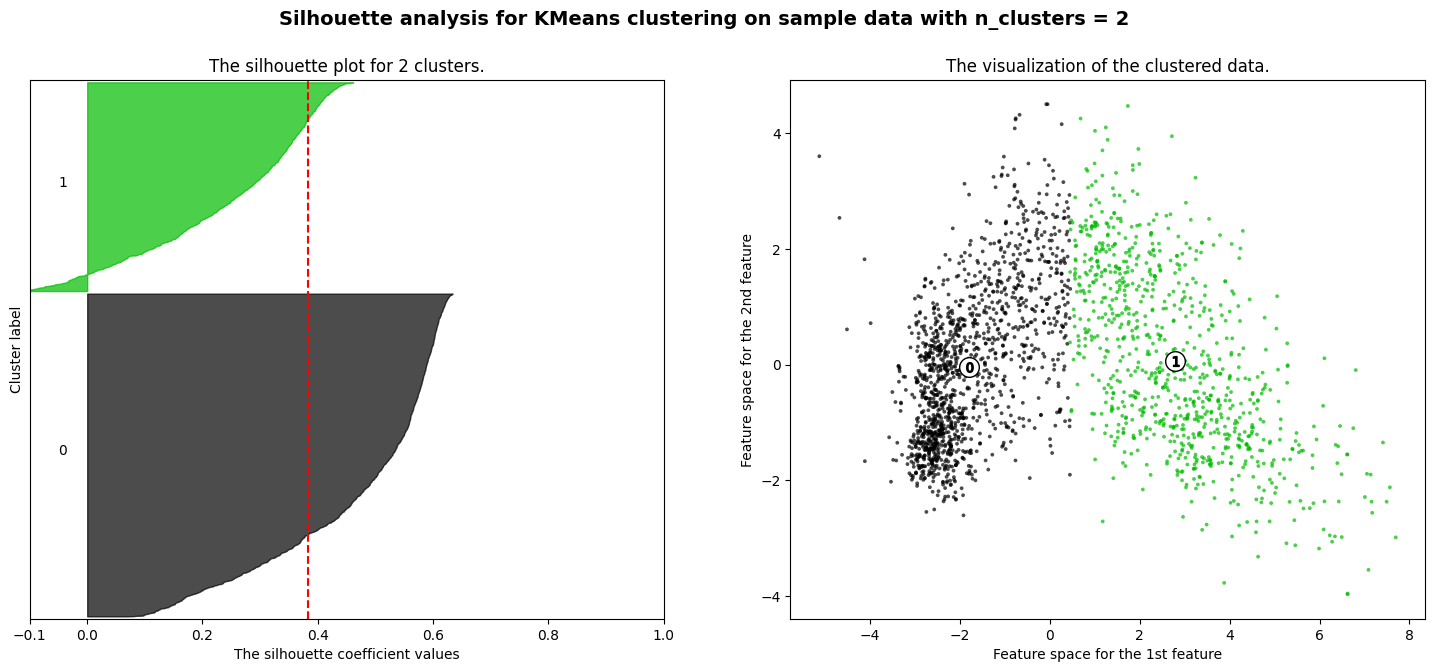

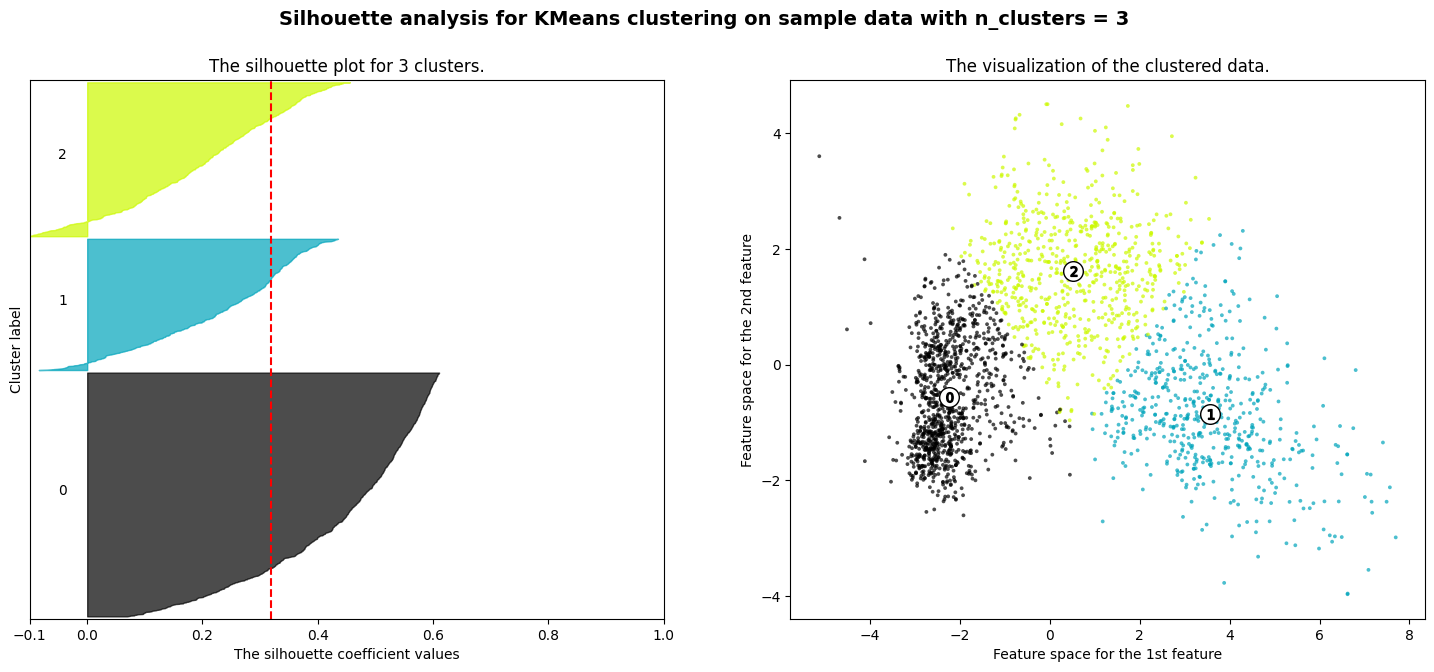

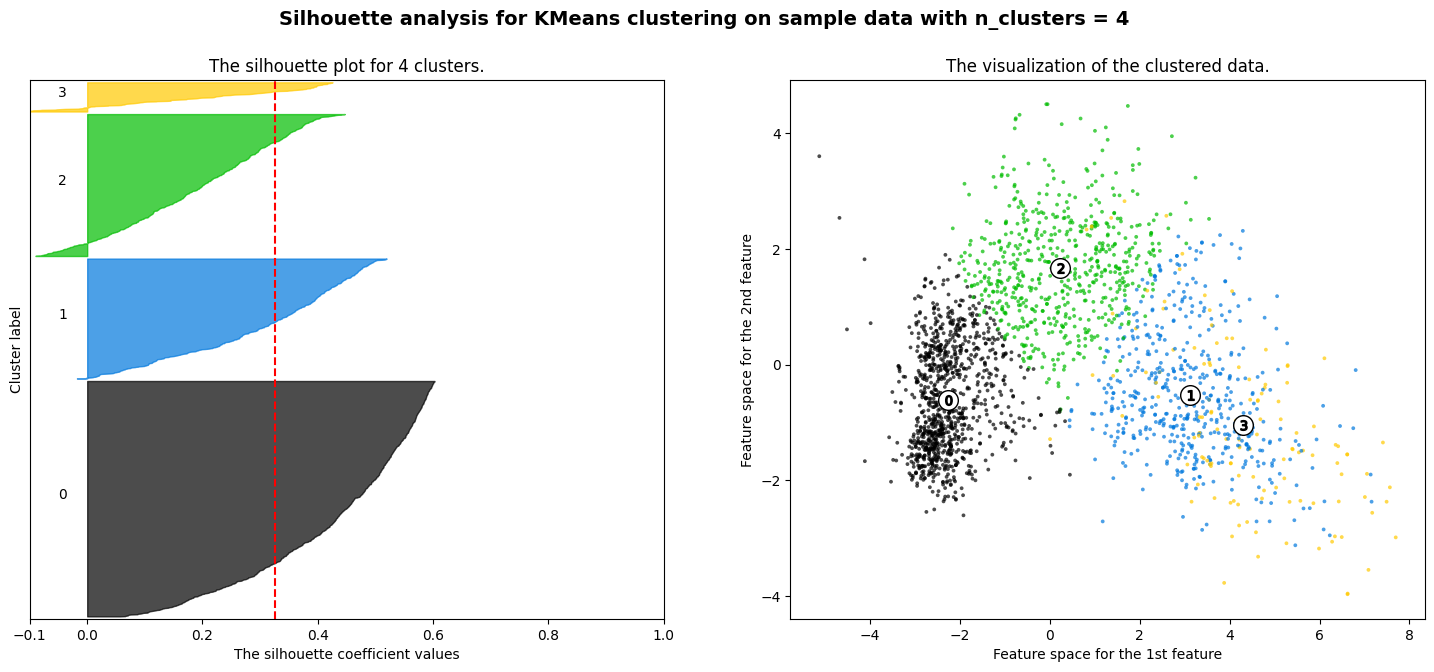

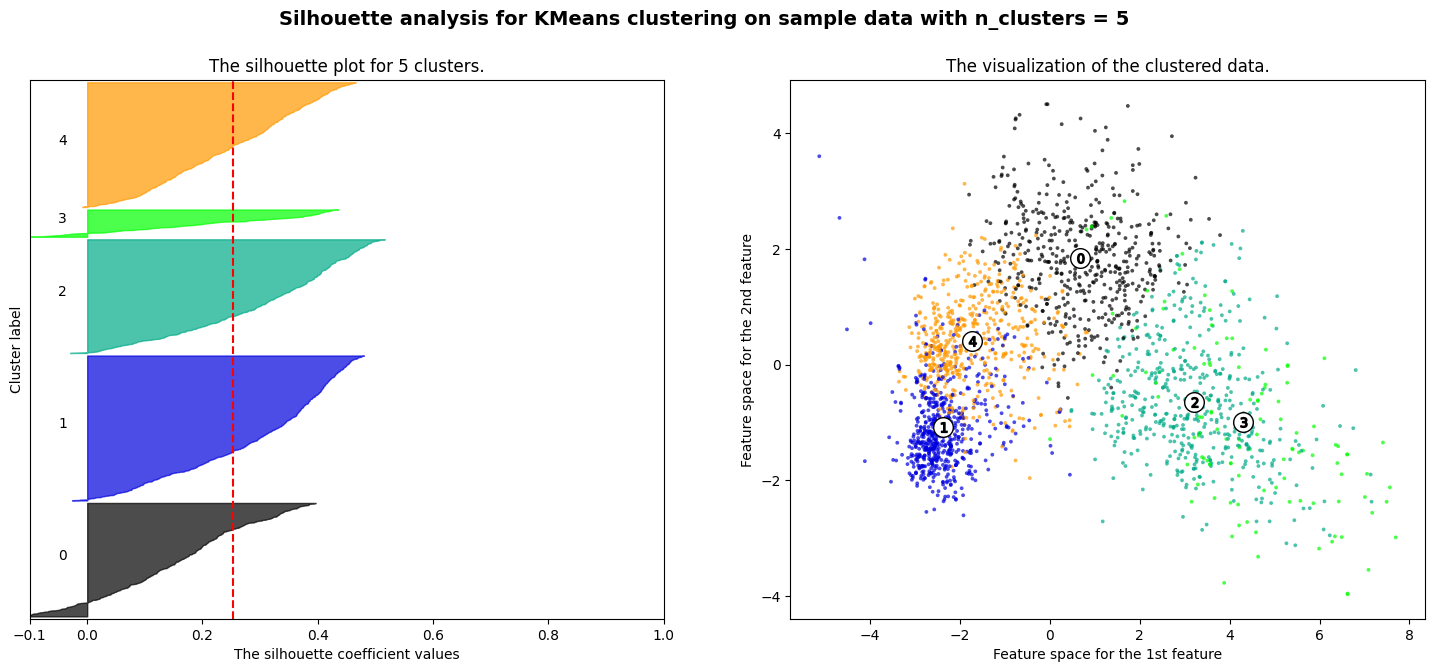

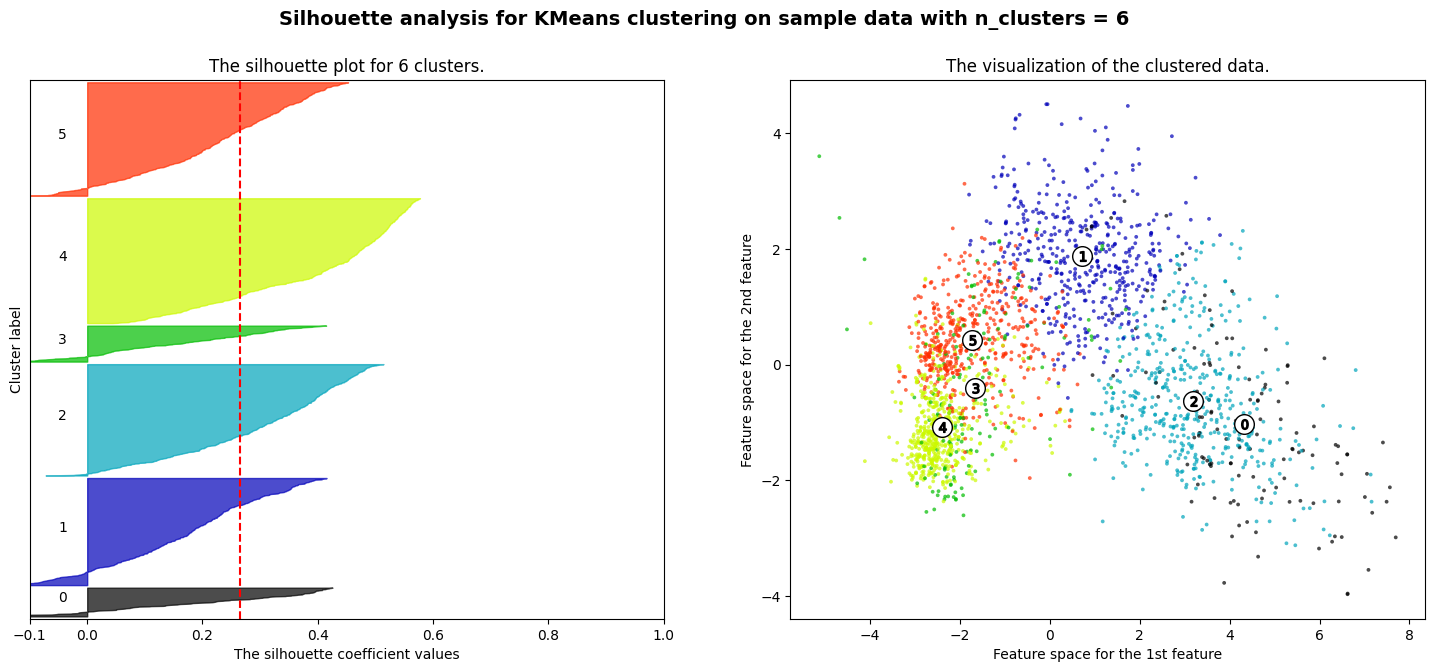

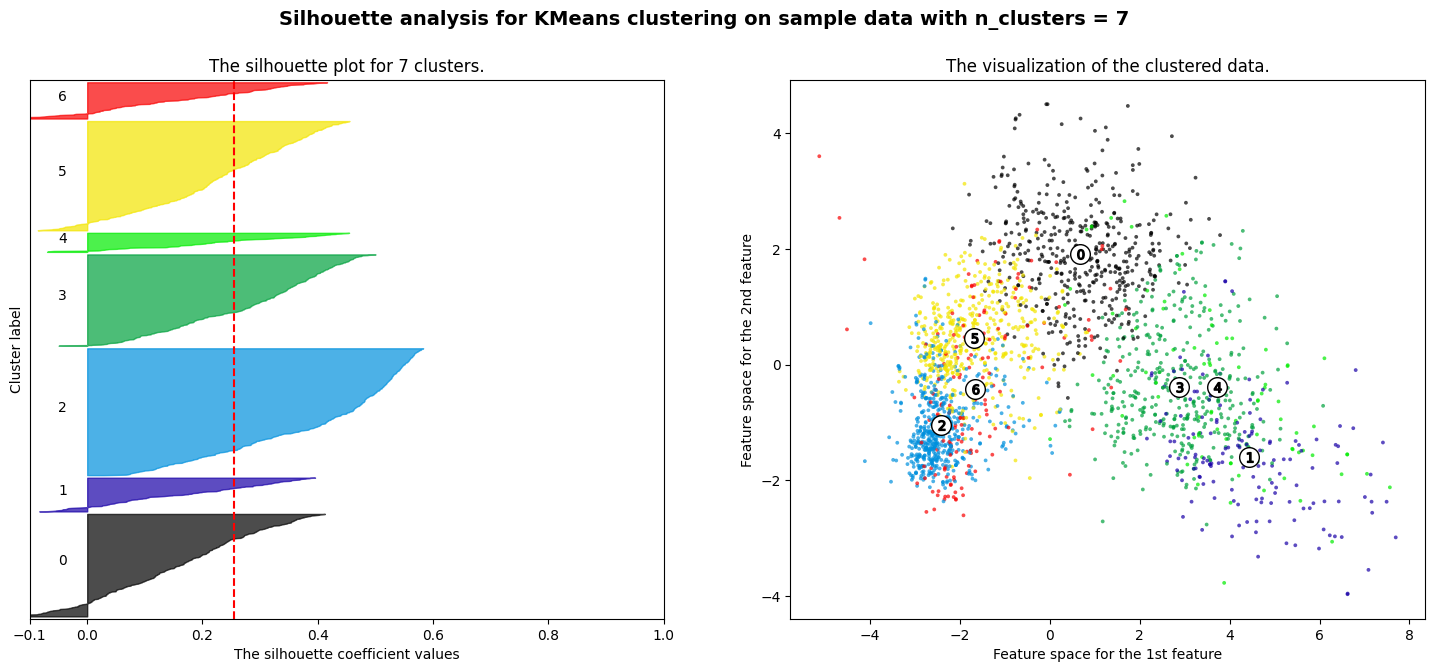

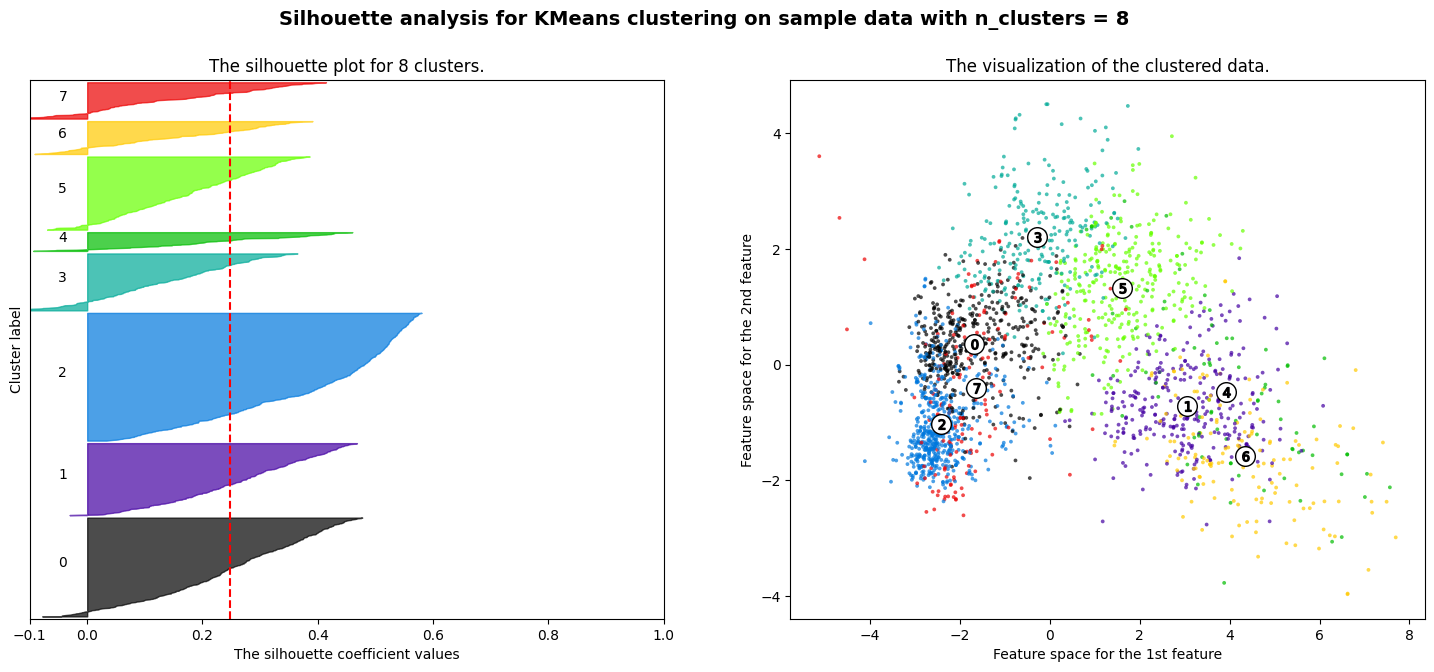

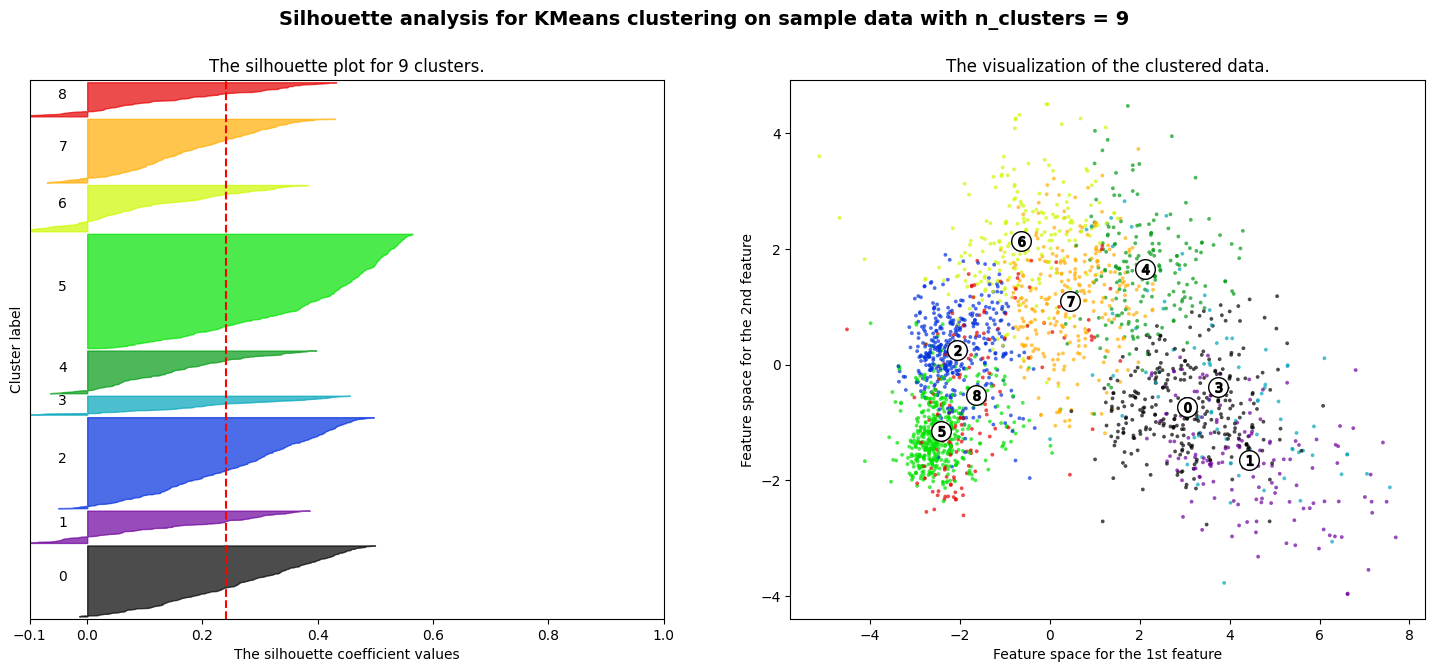

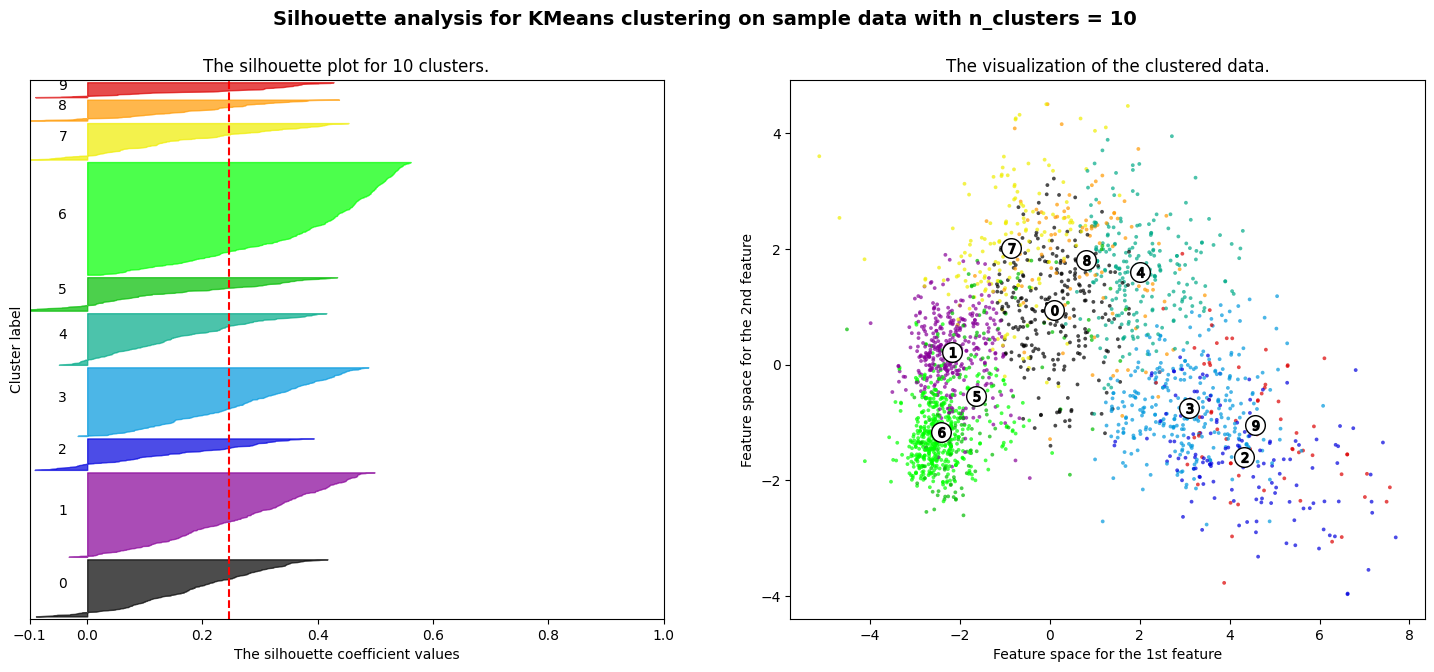

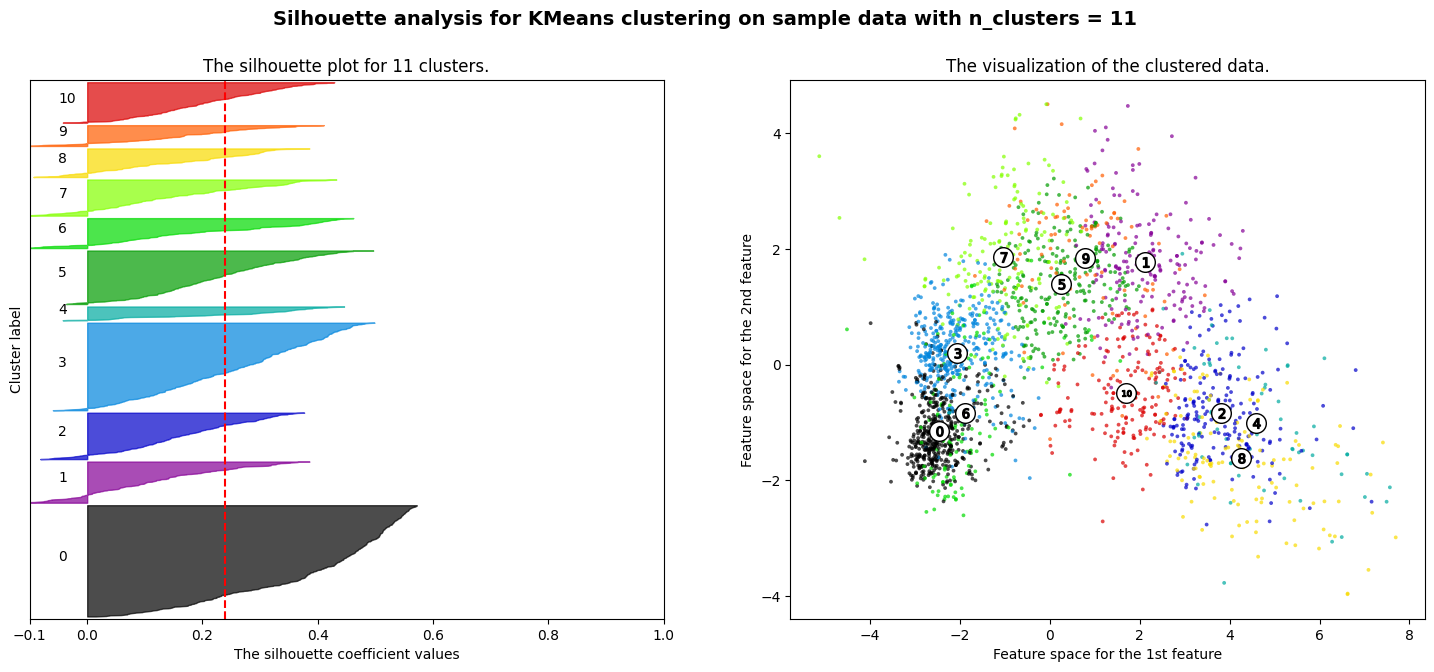

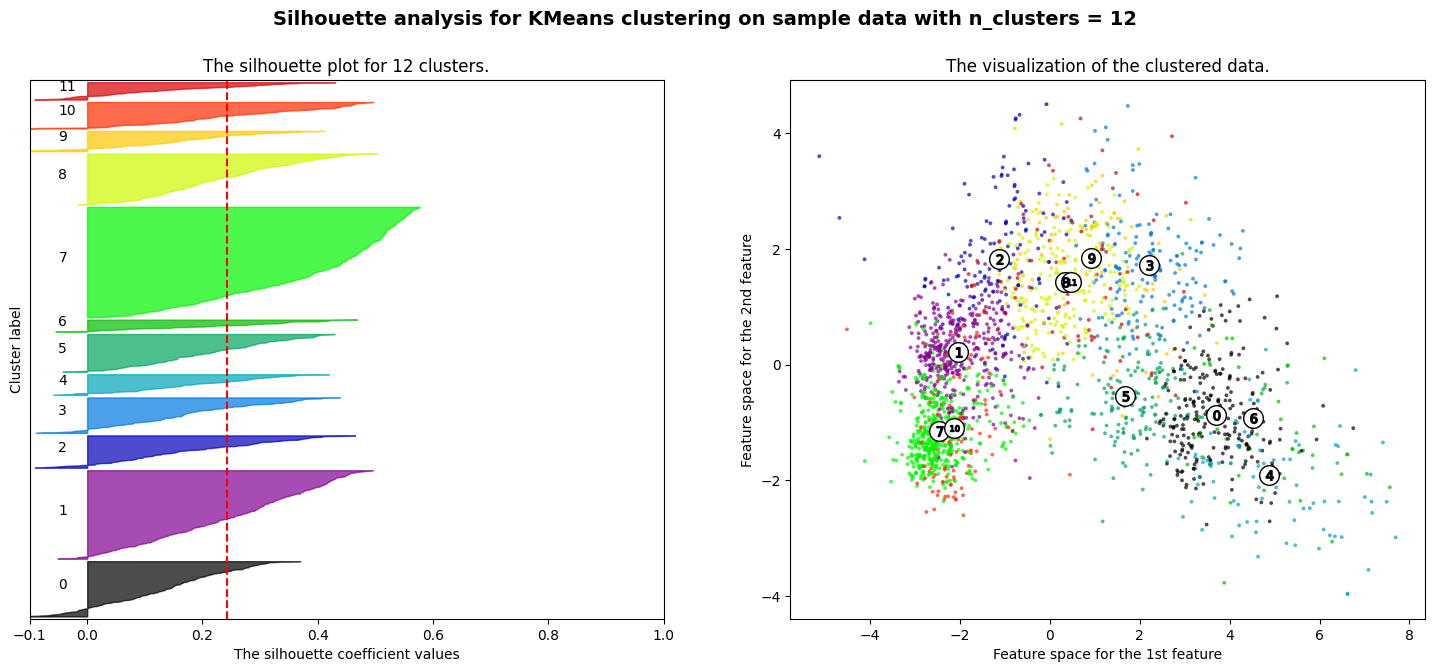

In [30]:
# Set the range of cluster numbers to evaluate
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


pipe1 = Pipeline([
    ('kmeans', KMeans(n_clusters=3, init='k-means++', random_state=42))
])

# For each number of clusters, create and plot a silhouette plot
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])

    # Set the number of clusters in the KMeans model
    pipe1.named_steps.kmeans.set_params(n_clusters=n_clusters, random_state=42)

    # Fit the data and obtain cluster labels
    cluster_labels = pipe1.fit_predict(df)

    # Calculate the silhouette score
    silhouette_avg = silhouette_score(df, cluster_labels)
    print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg)

    # The silhouette plot displays the silhouette scores for each sample
    # and visualizes how they are clustered
    sample_silhouette_values = silhouette_samples(df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for {} clusters.".format(n_clusters))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(df[:, 0], df[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = pipe1.named_steps.kmeans.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1,], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                    fontsize=14, fontweight='bold')
    plt.savefig('silhouette%02d.pdf' % n_clusters)
plt.show()


Best Score by Silhoutte Plot:
- For n_clusters = 2 The average silhouette_score is : 0.38239020725602807

But for better customer segmentation and comparision with Agglomerative Clustering, I will consider
- For n_clusters = 4 The average silhouette_score is : 0.32548864451727305

In [43]:
# cluster df into 4 clusters
pipe1.named_steps.kmeans.set_params(n_clusters=4, random_state=42)
cluster_labels = pipe1.fit_predict(df)

marketing_k_means = marketing.copy()

# add cluster labels to the original df
marketing_k_means['cluster'] = cluster_labels

In [42]:
k_mean_df = marketing_k_means.groupby('cluster').agg({'ID': 'count',
                **{col: 'sum' for col in binary_vars},
                **{col: 'mean' for col in num_vars},
                **{col: most_frequent for col in cat_vars}}).reset_index()

k_mean_df.T

0             1            2           3
cluster                         0             1            2           3
ID                           1001           510          604         125
AcceptedCmp1                    0            50           17          77
AcceptedCmp2                    2             0            0          28
AcceptedCmp3                   73            32           38          20
AcceptedCmp4                    7            12           72          76
AcceptedCmp5                    0            57            3         103
Response                       89            88           65          92
Complain                       13             3            4           1
NumDealsPurchases        1.997003      1.437255     3.842715        1.24
NumWebPurchases          2.052947      5.227451     6.178808       5.576
NumCatalogPurchases      0.525475       5.75098     2.912252        5.96
NumStorePurchases        3.146853      8.443137     7.445364       8.136
NumWebVisitsMonth        6.478521      2.833333      5.81457       3.736
In_Relationship           0.64036      0.621569     0.675497       0.624
Income               34526.179321  74842.177451  56834.74255   79637.316
Age                     50.929071     55.266667    59.200331      51.776
Kidhome                  0.807193      0.047059     0.259934       0.048
Teenhome                 0.422577      0.213725     0.955298         0.2
Recency                 49.282717     50.047059    48.413907      47.256
MntWines                37.834166    521.486275   433.582781     920.816
MntFruits                4.905095     71.698039    19.384106      45.864
MntMeatProducts         22.451548    440.268627   125.428808     409.584
MntFishProducts          7.025974    102.692157     26.80298      67.696
MntSweetProducts         5.022977     72.258824    20.061258      52.992
MntGoldProds            15.041958     79.911765    56.243377      70.608
Education              Graduation    Graduation   Graduation  Graduation
Dt_Customer             Wednesday       Tuesday     Thursday    Thursday

- Cluster 0: have lower income, has more number of people, spending is lesser on almost all categories, and recorded the most complaints
- Cluster 1: have higher Income, spending is higher on Wines, Meat, Fish, Sweet and highest on Gold products
- Cluster 2: is a medium income class, with spendings almost average among all clusters. Their mean age is higher and NumberWebPurchases is higher
- Cluster 3: is the highest income group, they spend most Wines among all other categories, are more involved in accepting promotions and do not have kids and teens

<font color = 'cyan'>
Compared to the Agglomerative clustering, K-Means clustering seems to be a bettter solution. This is because:

- There is a visual seperation of classes for the 2 PCA components
- There is almost better dispersion of population across all 4 categories.

Moreover I can see a trend in the 4 clusters:
- Cluster 0: seems to be a majority working class people
- Cluster 1: is higher income working population
- Cluster 2: is retired or retiring class population
- Cluster 3: could be seen as richest section of the society

</font>

## Task 8 (10 points):
Show the results of a t-SNE analysis of the dataset.  Experiment with a variety of perplexity values and explain your final choice.  As with the previous questions, keep in mind that one of the goals of cluster analysis with this dataset is creating customer segments.  Can you define customer segments by examining the characteristics of each cluster?  How might you label the points in the t-SNE plot to show characteristics of each cluster?

In [38]:
def tsne_clusters(df):
    cat_attr = df.select_dtypes(include='object').columns.tolist()
    num_attr = df.select_dtypes(include='number').columns.tolist()

    # scale cat_attr and OneHotEncode num_attr using ColumnTransformer
    pre_pr = ColumnTransformer([
        ('scale', StandardScaler(), num_attr),
        ('onehot', OneHotEncoder(sparse_output=False), cat_attr)
    ])

    perplexity = [5, 10, 20, 30, 40, 50, 60, 70, 80]

    for p in perplexity:
        # create a pipeline with preprocessor and model
        pipe = Pipeline([
            ('preprocessor', pre_pr),
            ('tsne', TSNE(n_components=2, perplexity=p))
        ])

        data_transformed = pipe.fit_transform(df)

        # plot the clusters
        plt.figure(figsize=(5, 4))
        scatter = plt.scatter(data_transformed[:, 0],
                              data_transformed[:, 1],
                              cmap='rainbow')
        plt.title(f'Perplexity = {p}')
        plt.show()

    return df

In [39]:
tsne_df = marketing.copy()
tsne_df['spending'] = tsne_df['MntWines'] + tsne_df['MntFruits']\
    + tsne_df['MntMeatProducts'] + tsne_df['MntFishProducts']\
    + tsne_df['MntSweetProducts'] + tsne_df['MntGoldProds']

tsne_df['promotion'] = tsne_df['AcceptedCmp1'] + tsne_df['AcceptedCmp2']\
    + tsne_df['AcceptedCmp3'] + tsne_df['AcceptedCmp4']\
    + tsne_df['AcceptedCmp5']

tsne_df['purchase'] = tsne_df['NumWebPurchases'] + tsne_df['NumCatalogPurchases']\
    + tsne_df['NumStorePurchases'] + tsne_df['NumWebVisitsMonth']

tsne_df['kids'] = tsne_df['Kidhome'] + tsne_df['Teenhome']

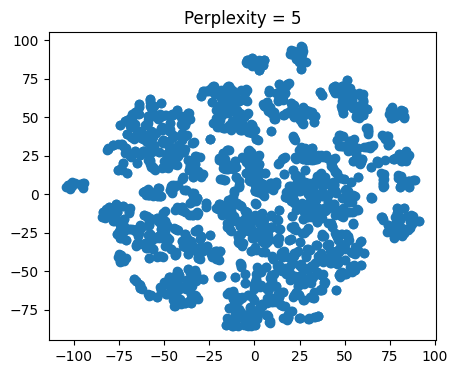

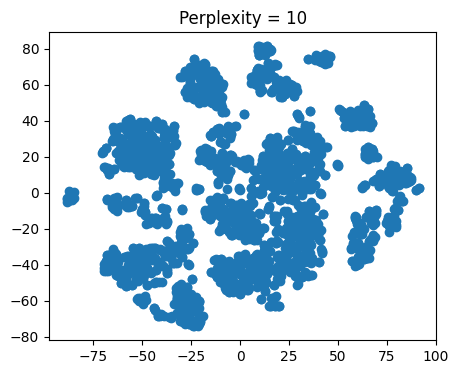

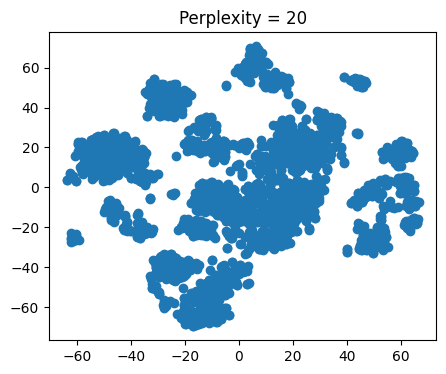

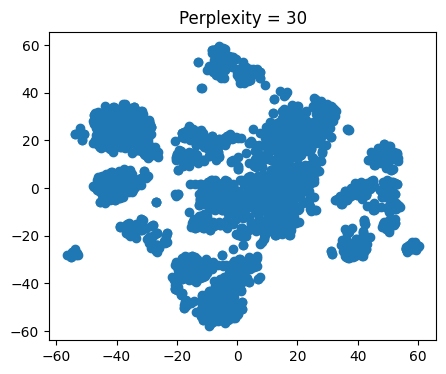

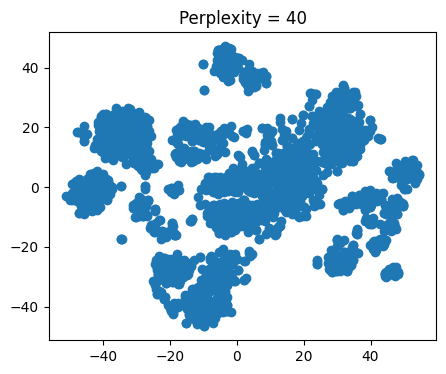

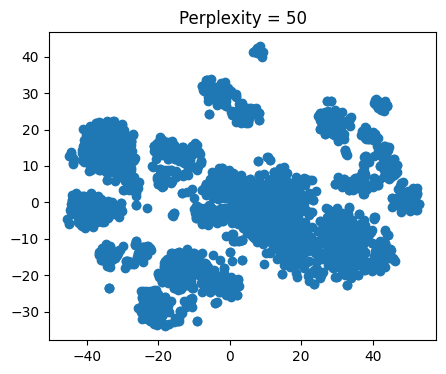

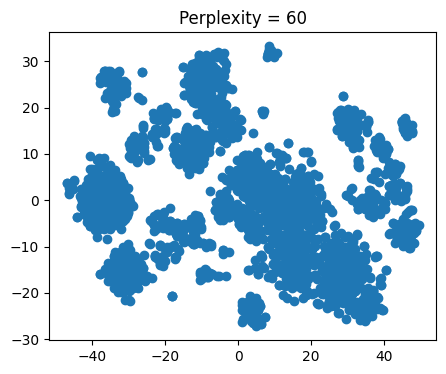

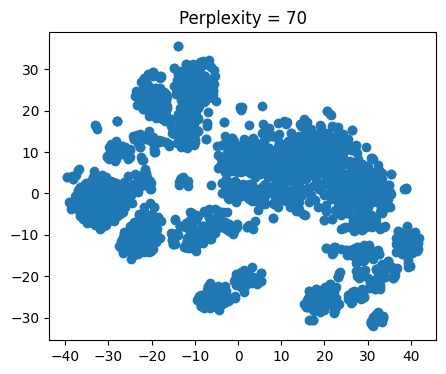

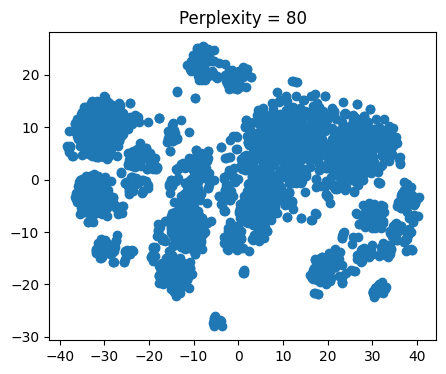

In [40]:
tsne_market = tsne_clusters(tsne_df)

In [36]:
tsne_df

ID   Education   Income  Kidhome  Teenhome Dt_Customer  Recency  \
0      5524  Graduation  58138.0        0         0      Monday       58   
1      2174  Graduation  46344.0        1         1      Friday       38   
2      4141  Graduation  71613.0        0         0     Tuesday       26   
3      6182  Graduation  26646.0        1         0      Sunday       26   
4      5324         PhD  58293.0        1         0    Saturday       94   
...     ...         ...      ...      ...       ...         ...      ...   
2235  10870  Graduation  61223.0        0         1   Wednesday       46   
2236   4001         PhD  64014.0        2         1      Monday       56   
2237   7270  Graduation  56981.0        0         0      Friday       91   
2238   8235      Master  69245.0        0         1    Thursday        8   
2239   9405         PhD  52869.0        1         1      Sunday       40   

      MntWines  MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
0          635         88              546              172                88   
1           11          1                6                2                 1   
2          426         49              127              111                21   
3           11          4               20               10                 3   
4          173         43              118               46                27   
...        ...        ...              ...              ...               ...   
2235       709         43              182               42               118   
2236       406          0               30                0                 0   
2237       908         48              217               32                12   
2238       428         30              214               80                30   
2239        84          3               61                2                 1   

      MntGoldProds  NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
0               88                  3                8                   10   
1                6                  2                1                    1   
2               42                  1                8                    2   
3                5                  2                2                    0   
4               15                  5                5                    3   
...            ...                ...              ...                  ...   
2235           247                  2                9                    3   
2236             8                  7                8                    2   
2237            24                  1                2                    3   
2238            61                  2                6                    5   
2239            21                  3                3                    1   

      NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
0                     4                  7             0             0   
1                     2                  5             0             0   
2                    10                  4             0             0   
3                     4                  6             0             0   
4                     6                  5             0             0   
...                 ...                ...           ...           ...   
2235                  4                  5             0             0   
2236                  5                  7             0             0   
2237                 13                  6             0             1   
2238                 10                  3             0             0   
2239                  4                  7             0             0   

      AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  Age  \
0                0             0             0         0         1   66   
1                0             0             0         0         0   69   
2                0             0             0         0    

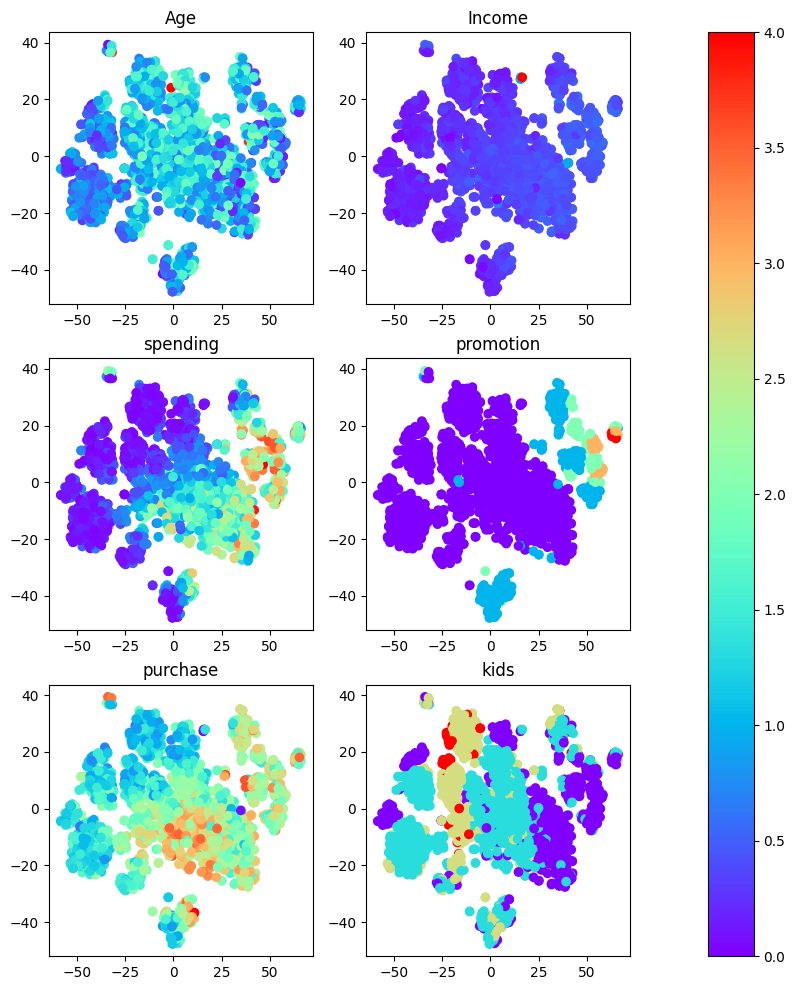

In [44]:
# make cluster with perplexity = 40
cat_attr = marketing.select_dtypes(include='object').columns.tolist()
num_attr = marketing.select_dtypes(include='number').columns.tolist()

# scale cat_attr and OneHotEncode num_attr using ColumnTransformer
pre_pr = ColumnTransformer([
    ('scale', StandardScaler(), num_attr),
    ('onehot', OneHotEncoder(sparse_output=False), cat_attr)
])

# create a pipeline with preprocessor and model
pipe = Pipeline([
    ('preprocessor', pre_pr),
    ('tsne', TSNE(n_components=2, perplexity=40))
])

data_transformed = pipe.fit_transform(tsne_df)

# plot the clusters, hue for 'Age'
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
scatter1 = axes[0, 0].scatter(data_transformed[:, 0], data_transformed[:, 1],
                      c=tsne_df['Age'], cmap='rainbow')
axes[0, 0].set_title('Age')
scatter2 = axes[0, 1].scatter(data_transformed[:, 0], data_transformed[:, 1],
                      c=tsne_df['Income'], cmap='rainbow')
axes[0, 1].set_title('Income')
scatter3 = axes[1, 0].scatter(data_transformed[:, 0], data_transformed[:, 1],
                      c=tsne_df['spending'], cmap='rainbow')
axes[1, 0].set_title('spending')
scatter4 = axes[1, 1].scatter(data_transformed[:, 0], data_transformed[:, 1],
                      c=tsne_df['promotion'], cmap='rainbow')
axes[1, 1].set_title('promotion')
scatter5 = axes[2, 0].scatter(data_transformed[:, 0], data_transformed[:, 1],
                        c=tsne_df['purchase'], cmap='rainbow')
axes[2, 0].set_title('purchase')
scatter6 = axes[2, 1].scatter(data_transformed[:, 0], data_transformed[:, 1],
                        c=tsne_df['kids'], cmap='rainbow')
axes[2, 1].set_title('kids')
cbar = plt.colorbar(scatter4, ax=axes, orientation='vertical', pad=0.1)
plt.show()


Accroding to the various tSNE plots, I hoave chosen the one with perplexity = 40. In this plot, we can see seperation of clusters is good for `spending`,  `promotion` and `kids` variables which were created.
- Customers with lesser kids have higher spending.
- Customers with higher purchase also tend to have higher kids.
- Spending and Income are alsmot averaged out for all the customers.


# NOTE
We **strongly** recommend restarting your kernel and running your complete notebook from top to bottom
before submitting your work to Canvas in both HTML and IPYNB formats.

**Disclaimer:** Used Github Copilot to generate the code for the above work.